In [1]:
import math
import os
import pickle
import random
import pandas as pd

import numpy as np
import torch

from matplotlib import pyplot as plt

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# https://github.com/rdbraatz/data-driven-prediction-of-battery-cycle-life-before-capacity-degradation/blob/master/Load%20Data.ipynb

remove_keys = [
  # FOLLOWS THE ORIGINAL REPO
  # remove batteries that do not reach 80% capacity
  'b1c8', 'b1c10', 'b1c12', 'b1c13', 'b1c22',      
  # remove batteries from batch 2 that are moved to batch 1
  'b2c7', 'b2c8', 'b2c9', 'b2c15', 'b2c16',      
  # remove noisy channels from batch3
  'b3c37', 'b3c2', 'b3c23', 'b3c32', 'b3c42', 'b3c43',
  
  # NEWLY DELETED HERE
  # remove outlier with abnormal capacity
  'b1c0', 'b1c18', 'b2c12', 'b2c44'
]
# There are four cells from batch1 that carried into batch2, we'll remove the data from batch2
# and put it with the correct cell from batch1
batch2_keys = ['b2c7', 'b2c8', 'b2c9', 'b2c15', 'b2c16']
batch1_keys = ['b1c0', 'b1c1', 'b1c2', 'b1c3', 'b1c4']
add_len = [662, 981, 1060, 208, 482]

temperature_feature_interval = 1
current_feature_interval = 1

cap_outlier_diff_threshold = 0.015

curve_ratio_min = 0.5
curve_ratio_max = 0.99
curve_ratio_steps = 9
curve_ratio_digits = 2
curve_ratio_step_size = (curve_ratio_max - curve_ratio_min) / curve_ratio_steps

In [3]:
data_dir_path = '/Users/keilongwong/Library/CloudStorage/OneDrive-個人/IPM PhD/Thesis/Data/Stanford University battery dataset/'
batch1 = pickle.load(open(os.path.join(data_dir_path,'batch1.pkl'), 'rb'))
batch2 = pickle.load(open(os.path.join(data_dir_path,'batch2.pkl'), 'rb'))
batch3 = pickle.load(open(os.path.join(data_dir_path,'batch3.pkl'), 'rb'))

for i, bk in enumerate(batch1_keys):
  batch1[bk]['cycle_life'] = batch1[bk]['cycle_life'] + add_len[i]
  for j in batch1[bk]['summary'].keys():
    if j == 'cycle':
      batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j] + len(batch1[bk]['summary'][j])))
    else:
      batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j]))
  last_cycle = len(batch1[bk]['cycles'].keys())
  for j, jk in enumerate(batch2[batch2_keys[i]]['cycles'].keys()):
    batch1[bk]['cycles'][str(last_cycle + j)] = batch2[batch2_keys[i]]['cycles'][jk]
    
batch = {**batch1, **batch2, **batch3}
for key in remove_keys:
  del batch[key]

In [4]:
max_temps = []
min_temps = []
for key in batch.keys():
  max_temps.append(np.max(batch[key]['summary']['Tmax']))
  min_temps.append(np.min(batch[key]['summary']['Tmin'][np.nonzero(batch[key]['summary']['Tmin'])]))
max_temp = np.max(max_temps)
min_temp = np.min(min_temps)

max_currents = []
min_currents = []
for key in batch.keys():
  for cycle in batch[key]['cycles'].keys():
    max_currents.append(np.max(batch[key]['cycles'][cycle]['I']))
    min_currents.append(np.min(batch[key]['cycles'][cycle]['I']))
max_current = np.max(max_currents)
min_current = np.min(min_currents)

In [12]:
data_path = '/Users/keilongwong/Library/CloudStorage/OneDrive-個人/IPM PhD/Thesis/Data/Samsung INR21700 30T 3Ah Li-ion Battery Data'

temp_to_test = ['40degC', '25degC', '10degC']

# loop all csv in data_path and append all rows in one dataframe
df = pd.DataFrame()
for dir in os.listdir(data_path):
    if not os.path.isdir(os.path.join(data_path, dir)):
        continue
    if dir not in temp_to_test:
        continue
    for file in os.listdir(os.path.join(data_path, dir)):
        if not file.endswith('.csv'):
            continue
        file_path = os.path.join(data_path, dir, file)
        # print(file_path)
        time_stamp_line_idx = 0

        with open(file_path) as f:
            for i, line in enumerate(f):
                if 'Time Stamp' in line:
                    time_stamp_line_idx = i
                    break
        
        new_df = pd.read_csv(file_path, 
                                skiprows=time_stamp_line_idx + 2, 
                                header=None,
                                index_col=False,
                                names=['Time Stamp',
                                    'Step',
                                    'Status',
                                    'Prog Time',
                                    'Step Time',
                                    'Cycle',
                                    'Cycle Level',
                                    'Procedure',
                                    'Voltage',
                                    'Current',
                                    'Temperature',
                                    'Capacity',
                                    'WhAccu',
                                    'Cnt'],
                                )
        
        new_df['Timestamp'] = pd.to_datetime(new_df['Time Stamp']).apply(lambda x: x.timestamp())
        new_df['Exp Temperature'] = dir
        new_df['Cycle Name'] = file[:-4]
        new_df['Exp Name'] = dir + ': ' + file[:-4]
        df = pd.concat([df, new_df])
                
df = df[df['Status'].isin([
                           'DCH', 
                           'PAU', 
                           'CHA', 
                        #    'STO',
                           'TABLE', 
                        #    'MSG'
                           ])]
                
df.sort_values(by=['Timestamp'], inplace=True)

df['Status Consecutive'] = (df['Status'] != df['Status'].shift()).cumsum()
df['Status Unique'] = df['Status'] + df['Status Consecutive'].astype(str)

cycle_count = 0
for key, group in df.groupby('Exp Name', sort=False):
  df.loc[group.index, 'Cycle Num'] = cycle_count
  cycle_count += 1      

df.reset_index(drop=True, inplace=True)

/var/folders/h8/8jpw1q2n08b3k_kml79456t40000gn/T/ipykernel_4471/1107558537.py:25: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  new_df = pd.read_csv(file_path,
/var/folders/h8/8jpw1q2n08b3k_kml79456t40000gn/T/ipykernel_4471/1107558537.py:25: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  new_df = pd.read_csv(file_path,
/var/folders/h8/8jpw1q2n08b3k_kml79456t40000gn/T/ipykernel_4471/1107558537.py:25: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  new_df = pd.read_csv(file_path,
/var/folders/h8/8jpw1q2n08b3k_kml79456t40000gn/T/ipykernel_4471/1107558537.py:25: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  new_df = pd.read_csv(file_path,
/var/folders/h8/8jpw1q2n08b3k_kml79456t40000

In [13]:
df.to_csv('all_data.csv', index=False)

In [14]:
df

,Time Stamp,Step,Status,Prog Time,Step Time,Cycle,Cycle Level,Procedure,Voltage,Current,...,Capacity,WhAccu,Cnt,Timestamp,Exp Temperature,Cycle Name,Exp Name,Status Consecutive,Status Unique,Cycle Num
0,2/24/2019 5:19:40 PM,24,DCH,39:01:33.780,00:00:59.999,0,0,Samsung30T_NN_Char,4.17335,-0.15069,...,-0.00253,-0.01057,22.0,1.551029e+09,40degC,697_C20DisCh,40degC: 697_C20DisCh,1,DCH1,102.0
1,2/24/2019 5:20:40 PM,24,DCH,39:02:33.789,00:02:00.008,0,0,Samsung30T_NN_Char,4.17065,-0.15325,...,-0.00507,-0.02116,22.0,1.551029e+09,40degC,697_C20DisCh,40degC: 697_C20DisCh,1,DCH1,102.0
2,2/24/2019 5:21:40 PM,24,DCH,39:03:33.786,00:03:00.005,0,0,Samsung30T_NN_Char,4.16795,-0.15069,...,-0.00761,-0.03174,22.0,1.551029e+09,40degC,697_C20DisCh,40degC: 697_C20DisCh,1,DCH1,102.0
3,2/24/2019 5:22:40 PM,24,DCH,39:04:33.790,00:04:00.009,0,0,Samsung30T_NN_Char,4.16542,-0.15069,...,-0.01014,-0.04230,22.0,1.551029e+09,40degC,697_C20DisCh,40degC: 697_C20DisCh,1,DCH1,102.0
4,2/24/2019 5:23:40 PM,24,DCH,39:05:33.795,00:05:00.014,0,0,Samsung30T_NN_Char,4.16306,-0.15325,...,-0.01268,-0.05287,22.0,1.551029e+09,40degC,697_C20DisCh,40degC: 697_C20DisCh,1,DCH1,102.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1477262,3/31/2019 12:39:45 AM,81,PAU,35:38:21.729,00:09:59.308,0,0,Samsung30T_CyclesB,4.05684,0.00000,...,-0.42082,-1.62428,67.0,1.553993e+09,10degC,756_PausCycl,10degC: 756_PausCycl,2851,PAU2851,102.0
1477263,3/31/2019 12:39:46 AM,81,PAU,35:38:22.228,00:09:59.807,0,0,Samsung30T_CyclesB,4.05684,0.00000,...,-0.42082,-1.62428,67.0,1.553993e+09,10degC,756_PausCycl,10degC: 756_PausCycl,2851,PAU2851,102.0
1477264,3/31/2019 12:39:46 AM,81,PAU,35:38:22.327,00:09:59.906,0,0,Samsung30T_CyclesB,4.05684,0.00000,...,-0.42082,-1.62428,67.0,1.553993e+09,10degC,756_PausCycl,10degC: 756_PausCycl,2851,PAU2851,102.0
1477265,3/31/2019 12:39:46 AM,81,PAU,35:38:22.429,00:10:00.008,0,0,Samsung30T_CyclesB,4.05684,0.00000,...,-0.42082,-1.62428,67.0,1.553993e+09,10degC,756_PausCycl,10degC: 756_PausCycl,2851,PAU2851,102.0


In [85]:
cycle_configs = [
  [('40degC: 697_C20DisCh', 'ALL'), ('40degC: 697_C20DisCh', 'CHA3')],
  [('40degC: 697_Dis_0p5C', 'ALL'), ('40degC: 697_Dis_0p5C', 'CHA9')],
  [('40degC: 697_Dis_2C', ['DCH11', 'PAU12', 'CHA13']), ('40degC: 697_Dis_2C', 'CHA13')],
  # very short charging cycle
  # [('40degC: 697_Dis_2C', ['PAU14', 'DCH15', 'PAU16', 'CHA17']), ('40degC: 697_Dis_2C', 'CHA17')],
  [('40degC: 710_UDDS', 'ALL'), ('40degC: 710_Charge3', 'CHA925')],
  [('40degC: 710_HWFET', 'ALL'), ('40degC: 710_Charge4', 'CHA931')],
  [('40degC: 710_LA92', 'ALL'), ('40degC: 710_Charge5', 'CHA939')],
  [('40degC: 710_US06', 'ALL'), ('40degC: 710_Charge6', 'CHA945')],
  [('40degC: 710_Mixed1', 'ALL'), ('40degC: 710_Charge7', 'CHA949')],
  [('40degC: 710_Mixed2', 'ALL'), ('40degC: 710_Charge8', 'CHA955')],
  [('40degC: 722_Cap_1C', 'ALL'), ('40degC: 722_Charge10', 'CHA961')],
  [('40degC: 722_Mixed3', 'ALL'), ('40degC: 722_Charge11', 'CHA965')],
  [('40degC: 722_Mixed4', 'ALL'), ('40degC: 722_Charge12', 'CHA971')],
  [('40degC: 722_Mixed5', 'ALL'), ('40degC: 722_Charge13', 'CHA979')],
  [('40degC: 722_Mixed6', 'ALL'), ('40degC: 722_Charge14', 'CHA985')],
  [('40degC: 722_Mixed7', 'ALL'), ('40degC: 722_Charge15', 'CHA995')],
  [('40degC: 722_Mixed8', 'ALL'), ('40degC: 722_Charge16', 'CHA1001')],

  # abnormally high charged capacity
  # [('25degC: 729_C20DisCh', 'ALL'), ('25degC: 729_C20DisCh', 'CHA1863')],
  [('25degC: 729_Dis_0p5C', 'ALL'), ('25degC: 729_Dis_0p5C', 'CHA1867')],
  [('25degC: 729_Dis_2C', ['DCH1869', 'PAU1870', 'CHA1871']), ('25degC: 729_Dis_2C', 'CHA1871')],
  [('25degC: 729_Dis_2C', ['PAU1872', 'DCH1873', 'PAU1874', 'CHA1875']), ('25degC: 729_Dis_2C', 'CHA1875')],
  [('25degC: 734_Cap_1C', 'ALL'), ('25degC: 734_Charge2', 'CHA1883')],
  [('25degC: 734_UDDS', 'ALL'), ('25degC: 734_Charge3', 'CHA1889')],
  [('25degC: 734_HWFET', 'ALL'), ('25degC: 734_Charge4', 'CHA1895')],
  [('25degC: 734_LA92', 'ALL'), ('25degC: 734_Charge5', 'CHA1901')],
  [('25degC: 734_US06', 'ALL'), ('25degC: 734_Charge6', 'CHA1905')],
  [('25degC: 734_Mixed1', 'ALL'), ('25degC: 734_Charge7', 'CHA1911')],
  [('25degC: 734_Mixed2', 'ALL'), ('25degC: 734_Charge8', 'CHA1917')],
  [('25degC: 740_Mixed3', 'ALL'), ('25degC: 740_Charge11', 'CHA1927')],
  [('25degC: 740_Mixed4', 'ALL'), ('25degC: 740_Charge12', 'CHA1933')],
  [('25degC: 740_Mixed5', 'ALL'), ('25degC: 740_Charge13', 'CHA1939')],
  [('25degC: 740_Mixed6', 'ALL'), ('25degC: 740_Charge14', 'CHA1945')],
  [('25degC: 740_Mixed7', 'ALL'), ('25degC: 740_Charge15', 'CHA1949')],
  [('25degC: 740_Mixed8', 'ALL'), ('25degC: 740_Charge16', 'CHA1955')],

  [('10degC: 746_C20DisCh', 'ALL'), ('10degC: 746_C20DisCh', 'CHA2757')],
  [('10degC: 746_Dis_0p5C', 'ALL'), ('10degC: 746_Dis_0p5C', 'CHA2761')],
  [('10degC: 746_Dis_2C', ['DCH2763', 'PAU2764', 'DCH2765', 'PAU2766', 'CHA2767']), ('10degC: 746_Dis_2C', 'CHA2767')],
  [('10degC: 746_Dis_2C', ['PAU2768', 'DCH2769', 'PAU2770']), ('10degC: 752_Charge1', 'ALL'), ('10degC: 752_Charge1', 'CHA2771')],
  [('10degC: 752_Cap_1C', 'ALL'), ('10degC: 752_Charge2', 'CHA2775')],
  [('10degC: 752_UDDS', 'ALL'), ('10degC: 752_Charge3', 'CHA2781')],
  [('10degC: 752_HWFET', 'ALL'), ('10degC: 752_Charge4', 'CHA2785')],
  [('10degC: 752_LA92', 'ALL'), ('10degC: 752_Charge5', 'CHA2789')],
  [('10degC: 752_US06', 'ALL'), ('10degC: 752_Charge6', 'CHA2795')],
  [('10degC: 752_Mixed1', 'ALL'), ('10degC: 752_Charge7', 'CHA2801')],
  [('10degC: 752_Mixed2', 'ALL'), ('10degC: 752_Charge8', 'CHA2805')],
  [('10degC: 756_Cap_1C', 'ALL'), ('10degC: 756_Charge10', 'CHA2811')],
  [('10degC: 756_Mixed3', 'ALL'), ('10degC: 756_Charge11', 'CHA2817')],
  [('10degC: 756_Mixed4', 'ALL'), ('10degC: 756_Charge12', 'CHA2823')],
  [('10degC: 756_Mixed5', 'ALL'), ('10degC: 756_Charge13', 'CHA2829')],
  [('10degC: 756_Mixed6', 'ALL'), ('10degC: 756_Charge14', 'CHA2835')],
  [('10degC: 756_Mixed7', 'ALL'), ('10degC: 756_Charge15', 'CHA2841')],
  [('10degC: 756_Mixed8', 'ALL'), ('10degC: 756_Charge16', 'CHA2847')]
]

In [86]:
cycle_data = {}

for i, cycle_config in enumerate(cycle_configs):
  if len(cycle_config) == 3:
    cycle_names = [cycle_config[0], cycle_config[1]]
    charge_cycle_name = cycle_config[2]
  else:
    cycle_names = [cycle_config[0]]
    charge_cycle_name = cycle_config[1]
  
  if len(cycle_names) == 1 and cycle_names[0][1] == 'ALL':
    cycle_names.append(charge_cycle_name)
  
  cycle_df = pd.DataFrame()
  for cycle_name in cycle_names:
    if cycle_name[1] == 'ALL':
      selected_df = df[df['Exp Name'] == cycle_name[0]]
      if len(selected_df) <= 0:
        print(f'Cannot find cycle with exp name: {cycle_name[0]}')
      cycle_df = pd.concat([cycle_df, selected_df])
    elif type(cycle_name[1]) == str:
      selected_df = df[(df['Exp Name'] == cycle_name[0]) & (df['Status Unique'] == cycle_name[1])]
      if len(selected_df) <= 0:
        print(f'Cannot find cycle with exp name: {cycle_name[0]} and status: {cycle_name[1]}')
      cycle_df = pd.concat([cycle_df, selected_df])
    else:
      for status_name in cycle_name[1]:
        selected_df = df[(df['Exp Name'] == cycle_name[0]) & (df['Status Unique'] == status_name)]
        if len(selected_df) <= 0:
          print(f'Cannot find cycle with exp name: {cycle_name[0]} and status: {status_name}')
      cycle_df = pd.concat([cycle_df, selected_df])
  
  cap = 0
  charge_df = df[(df['Exp Name'] == charge_cycle_name[0]) & (df['Status Unique'] == charge_cycle_name[1]) & (df['Voltage'].astype(float) < 4.19)]
  if len(charge_df) <= 0:
    print(f'Cannot find charge cycle with exp name: {charge_cycle_name[0]} and status: {charge_cycle_name[1]}')
  cap = np.trapz(charge_df['Current'], charge_df['Timestamp']) / 3600
  # cap = charge_df['Capacity'].max()
  cap = cap / 3.0
  
  cycle_data[i] = {
    'cycle': cycle_df,
    'cap': cap
  }

In [87]:
test_df = df[(df['Status Unique'] == 'CHA1863')]

np.trapz(test_df['Current'].values, test_df['Timestamp'].values) / 3600 / 3.0

1.0457576962962964

In [88]:
caps = []

for i in range(len(cycle_data)):
  caps.append(cycle_data[i]['cap'])
  print(i, cycle_data[i]['cap'])

0 0.8018401666666667
1 0.6996853333333334
2 0.6996995
3 0.6496814999999999
4 0.6496956666666666
5 0.6497098333333332
6 0.6496885833333332
7 0.6496956666666666
8 0.6496814999999999
9 0.6996569999999999
10 0.6496956666666666
11 0.6497098333333332
12 0.6497098333333332
13 0.6663477777777778
14 0.6496749999999999
15 0.6497183333333334
16 0.6830268333333334
17 0.6663541666666667
18 0.6663966666666666
19 0.6663541666666667
20 0.6330371666666665
21 0.6330371666666665
22 0.6330371666666665
23 0.6330229999999999
24 0.6330229999999999
25 0.6330229999999999
26 0.6163644999999999
27 0.6163644999999999
28 0.6163644999999999
29 0.6163644999999999
30 0.6163786666666665
31 0.6163786666666665
32 0.7848546666666668
33 0.6330371666666665
34 0.6330371666666665
35 0.6163786666666665
36 0.6163928333333332
37 0.5830616666666666
38 0.5830616666666666
39 0.5830758333333332
40 0.5830616666666666
41 0.5830687499999999
42 0.5830616666666666
43 0.6163643309716665
44 0.5830615296277777
45 0.5830757191472221
46 0.58

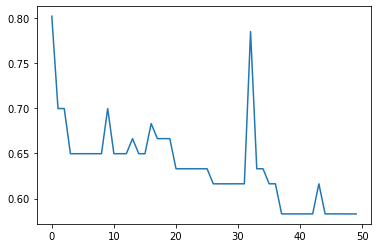

In [89]:
plt.plot(caps)